In [1]:
!pip install spacy

In [2]:
import pandas as pd 
import numpy as np 
import os 
import time
import random 
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import pathlib
import spacy
from spacy.tokenizer import Tokenizer 
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from spacy.attrs import ORTH, NORM
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer as KerasTokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import * 
from keras.layers.core import Dense ,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils, to_categorical
from keras.optimizers import Adam, SGD
from keras import callbacks 
import glob
import json

device_name = tf.test.gpu_device_name() 
if device_name != '/device:GPU:0':
  print('GPU device not found.')
print(device_name)

Using TensorFlow backend.


/device:GPU:0


In [3]:
__CWDIR__ = pathlib.Path.cwd()
DATASET_DIR = __CWDIR__.joinpath('drive/My Drive/amazon_sentiment_analysis_merge.csv')

In [4]:
DATASET_DIR

PosixPath('/content/drive/My Drive/amazon_sentiment_analysis_merge.csv')

In [8]:
def barChartsPlot(dict_, title=None):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    type_ = list(dict_.keys())
    values_ = list(dict_.values())
    ax.bar(type_,values_)
    plt.title(title)
    return plt


In [5]:
df = pd.read_csv(DATASET_DIR)

{5.0: 138950, 1.0: 6009, 2.0: 5218, 4.0: 31163, 3.0: 12964}


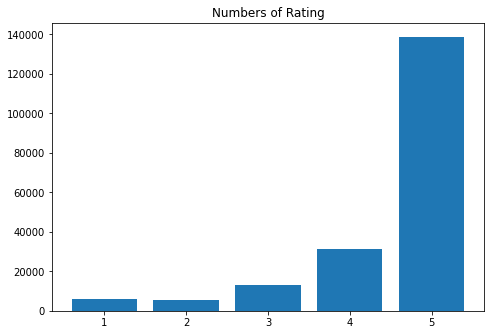

{'pos': 170113, 'neg': 11227, 'neu': 12964}


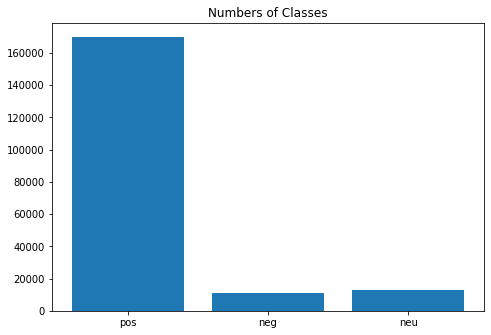

In [9]:
rating_dict = {}
for i in df['reviewRating']:
    if i not in rating_dict:
        rating_dict[i] = 0
    rating_dict[i]+=1    
plt = barChartsPlot(rating_dict, title='Numbers of Rating')
print(rating_dict)
plt.show()

classes = {}
for i in df['rateLabel']:
    if i not in classes:
        classes[i] = 0
    classes[i]+=1    
plt = barChartsPlot(classes, title='Numbers of Classes')
print(classes)
plt.show()

In [11]:
pos_dataset = df.loc[df['rateLabel'] == 'pos']
neu_dataset = df.loc[df['rateLabel'] == 'neu']
neg_dataset = df.loc[df['rateLabel'] == 'neg']
print(f"pos:{len(pos_dataset)}, neu:{len(neu_dataset)}, neg:{len(neg_dataset)}")

pos_dataset = pos_dataset[:8000]
neu_dataset = neu_dataset[:8000]
neg_dataset = neg_dataset[:8000]
dataset = pd.concat([pos_dataset, neu_dataset, neg_dataset], axis=0).reset_index(drop=True)

pos:170113, neu:12964, neg:11227


In [12]:
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")

In [20]:
x = dataset['reviewText'].tolist()
y = dataset['rateLabel'].tolist() 

In [21]:
special_case = {
    "couldn't" : [{ORTH: "could"}, {ORTH: "n't", NORM: "not"}],
    "don't" : [{ORTH: "do"}, {ORTH: "n't", NORM: "not"}],
    "wasn't" : [{ORTH: "was"}, {ORTH: "n't", NORM: "not"}],
    "isn't" : [{ORTH: "is"}, {ORTH: "n't", NORM: "not"}],
    "it's" : [{ORTH: "it"}, {ORTH: "'s", NORM: "is"}],
    "wouldn't": [{ORTH: "would"}, {ORTH: "n't", NORM: "not"}],
}

class Parser:
    def __init__(self, sent_segmenter=True, custom_tokenize=True):
        self.pre_model = spacy.load("en_core_web_sm")
        
        if sent_segmenter:
            self.boundary = re.compile('^[0-9]$')
            self.pre_model.add_pipe(self.custom_seg, before='parser')
        
        if custom_tokenize:
            self.pre_model.tokenizer = self.custom_tokenizer(self.pre_model)
            
            for k,v in special_case.items():
                self.pre_model.tokenizer.add_special_case(k, v)
            
        print(f"Pipe names : {self.pre_model.pipe_names}")
    
    def custom_tokenizer(self, nlp_model):
        infix_re = re.compile(r'''[.\,\?\:\;\...\‘\’\`\“\”\"\'~]''')
        prefix_re = compile_prefix_regex(self.pre_model.Defaults.prefixes)
        suffix_re = compile_suffix_regex(self.pre_model.Defaults.suffixes)
        
        return Tokenizer(self.pre_model.vocab, prefix_search=prefix_re.search,
                                               suffix_search=suffix_re.search,
                                               infix_finditer=infix_re.finditer,
                                               token_match=None)

    def custom_seg(self, doc):
        prev = doc[0].text
        length = len(doc)
        for index, token in enumerate(doc):
            if (token.text == '.' and self.boundary.match(prev) and index!=(length - 1)):
                doc[index+1].sent_start = False
            prev = token.text
        return doc
    
    def sent_to_doc(self, sent):
        self.doc = self.pre_model(sent)
    
    def token_normalizer(self, token):
        if(token == "n't"):
            new_token = "not"
        else:
            new_token = token
        return new_token
    
    def remove_punct(self):
        if 'custom_seg' in self.pre_model.pipe_names:
            rlist = []
            for sent in (self.doc).sents:
                temp_ = []
                for token in sent:
                    if token.pos_ == 'PUNCT':
                        continue
                    new_token = self.token_normalizer(token.text)
                    temp_.append(new_token)
                rlist.append(temp_)
            return rlist

In [16]:
X_list = []
parser_obj = Parser(sent_segmenter=True)
for idx, review in tqdm(enumerate(x)):
    parser_obj.sent_to_doc(review)
    parsed_list = parser_obj.remove_punct()
    str_ = ""
    for idx_, list_ in enumerate(parsed_list):
        str_ += ' '.join(list_)
        str_ += ' '
    X_list.append(str_)

0it [00:00, ?it/s]

Pipe names : ['tagger', 'custom_seg', 'parser', 'ner']


24000it [12:20, 32.41it/s]


In [61]:
X_copy = X_list.copy() 
tk = KerasTokenizer(lower = True)
tk.fit_on_texts(X_copy)
X_seq = tk.texts_to_sequences(X_copy)
X_pad = pad_sequences(X_seq, maxlen=200, padding='post')
# tk.word_counts 

In [62]:
from sklearn.preprocessing import OneHotEncoder
Y = np.array(y)
Y = OneHotEncoder().fit_transform(Y.reshape(-1,1)).toarray()

In [64]:
from sklearn.model_selection import train_test_split 
x_traindf, x_testdf, y_traindf, y_testdf = train_test_split(X_pad, Y, test_size=0.3, shuffle=True, random_state=1)
# x_testdf, x_valdf, y_testdf, y_valdf = train_test_split(x_testdf, y_testdf, test_size=1/3, shuffle=True, random_state=1)

In [65]:
x_traindf.shape

(16800, 200)

In [66]:
batch_size = 64
max_words = 200 
vocabulary = len(tk.word_counts.keys())+1
opt = keras.optimizers.RMSprop(learning_rate=0.005, epsilon=1e-06)
# opt = keras.optimizers.Adam()

In [67]:
model = keras.Sequential() 
model.add(Embedding(input_dim=vocabulary, output_dim=8, input_length=max_words))
# model.add(Flatten())

model.add(Bidirectional(LSTM(200, dropout=0.2, recurrent_dropout=0.2)))

model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 8)            140744    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 400)               334400    
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 1203      
_________________________________________________________________
activation_6 (Activation)    (None, 3)                 0         
Total params: 476,347
Trainable params: 476,347
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
history = model.fit(x_traindf, y_traindf, epochs=15, batch_size=256 , validation_data=(x_testdf, y_testdf))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16800 samples, validate on 7200 samples
Epoch 1/15
16800/16800 [==============================] - 82s 5ms/step - loss: 1.0057 - accuracy: 0.5079 - val_loss: 0.7637 - val_accuracy: 0.5976
Epoch 2/15
16800/16800 [==============================] - 80s 5ms/step - loss: 0.7125 - accuracy: 0.6705 - val_loss: 0.6692 - val_accuracy: 0.6525
Epoch 3/15
16800/16800 [==============================] - 80s 5ms/step - loss: 0.6414 - accuracy: 0.7167 - val_loss: 0.5647 - val_accuracy: 0.7204
Epoch 4/15
16800/16800 [==============================] - 81s 5ms/step - loss: 0.5221 - accuracy: 0.7608 - val_loss: 0.5236 - val_accuracy: 0.7632
Epoch 5/15
16800/16800 [==============================] - 80s 5ms/step - loss: 0.4668 - accuracy: 0.7900 - val_loss: 0.4897 - val_accuracy: 0.7774
Epoch 6/15
16800/16800 [==============================] - 81s 5ms/step - loss: 0.4373 - accuracy: 0.8091 - val_loss: 0.4907 - val_accuracy: 0.7775
Epoch 7/15
16800/16800 [==============================] - 81s 5ms/ste

In [72]:
model.save('cp.h5')

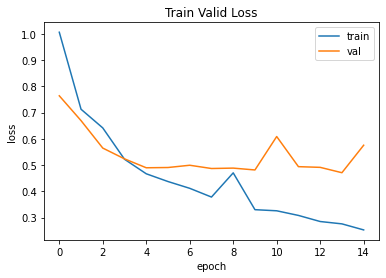

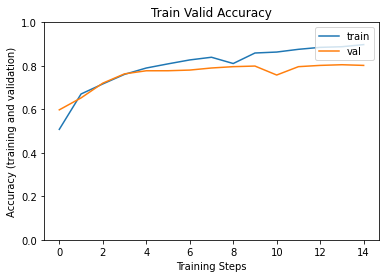

In [73]:
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Train Valid Loss')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'val'], loc='upper right')

plt.figure()
plt.title('Train Valid Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history.history["accuracy"],label='train')
plt.plot(history.history["val_accuracy"],label='val')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [74]:
score = model.evaluate(x_testdf, y_testdf, verbose=1)
print("Test Lost:", score[0])
print("Test Accuracy:", score[1])

7200/7200 [==============================] - 20s 3ms/step
Test Lost: 0.5754961547586653
Test Accuracy: 0.8020833134651184


In [75]:
pred = model.predict(x_testdf, verbose=1)
y_pred = np.argmax(pred,axis=-1)
int_label_array = np.array(y_testdf)
y_true = np.where(int_label_array==1)[1]

from sklearn.metrics import classification_report
print(classification_report(y_pred, y_true))

7200/7200 [==============================] - 19s 3ms/step
              precision    recall  f1-score   support

           0       0.83      0.69      0.75      2771
           1       0.62      0.78      0.69      1962
           2       0.96      0.95      0.95      2467

    accuracy                           0.80      7200
   macro avg       0.80      0.80      0.80      7200
weighted avg       0.82      0.80      0.80      7200



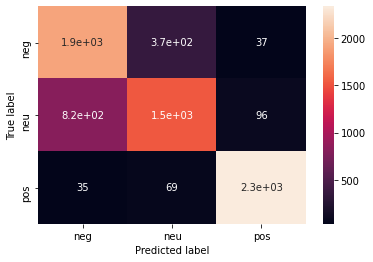

In [85]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = ['neg', 'neu', 'pos']

cm = confusion_matrix(y_true, y_pred)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalize the matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(cm_df, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [86]:
continue_training = keras.models.load_model('cp.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [88]:
history2 = continue_training.fit(x_traindf, y_traindf, epochs=5, batch_size=256 , validation_data=(x_testdf, y_testdf))

Train on 16800 samples, validate on 7200 samples
Epoch 1/5
16800/16800 [==============================] - 82s 5ms/step - loss: 0.2466 - accuracy: 0.9018 - val_loss: 0.4944 - val_accuracy: 0.8042
Epoch 2/5
16800/16800 [==============================] - 81s 5ms/step - loss: 0.2972 - accuracy: 0.8842 - val_loss: 0.5024 - val_accuracy: 0.8050
Epoch 3/5
16800/16800 [==============================] - 82s 5ms/step - loss: 0.2404 - accuracy: 0.9035 - val_loss: 0.5038 - val_accuracy: 0.8060
Epoch 4/5
16800/16800 [==============================] - 81s 5ms/step - loss: 0.2178 - accuracy: 0.9147 - val_loss: 0.5534 - val_accuracy: 0.8058
Epoch 5/5
16800/16800 [==============================] - 79s 5ms/step - loss: 0.2131 - accuracy: 0.9154 - val_loss: 0.5690 - val_accuracy: 0.7969
